# UNET model for wear and broken segmentation in micro-milling

## Import libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from functions import get_train_test_dataset, decode_tool_img, decode_tool_target, get_unet_model, get_microm, get_unet,  get_unet_mini, get_wear_parameters
from functions import dice_loss, focal_loss, dice_weighted_loss, focal_weighted_loss, iou_loss, iou_weighted_loss, categorical_weighted_loss, iou_loss, iou_wear_metric, iou_broken_metric, focal_categorical_loss
import datetime
from sklearn.metrics import r2_score

In [3]:
img_size = (256, 320)
original_scale = 4
batch_size = 4
epochs = 100
test_size = 0.15
intro = 'test'+str(test_size)+'_bs'+str(batch_size)

metrics = [
    dice_loss, 
    focal_loss, 
    iou_wear_metric,
    iou_broken_metric,
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_io_u'), 
    tf.keras.metrics.CategoricalCrossentropy()
]
metrics_name = ['loss'] + [metric.__name__ for metric in metrics[:-2]] + [metric.name for metric in metrics[-2:]]


loss_functions = [
    dice_weighted_loss(0.4, 0.3, 0.3),
    dice_loss,
    focal_weighted_loss(0.4, 0.3, 0.3),
    focal_loss,
    iou_weighted_loss(0.4, 0.3, 0.3),
    iou_loss,
    categorical_weighted_loss(0.4, 0.3, 0.3),
    tf.keras.losses.CategoricalCrossentropy(),
]
loss_names = [loss.__name__ for loss in loss_functions[:-1]] + [loss.name for loss in loss_functions[-1:]]


df_scale = pd.read_csv('data/scale_metrics.csv')

## Load dataset

In [4]:
df_tools = pd.read_csv('data/tools_dataset.csv')
df_tools['broken_path'] = df_tools['broken_path'].fillna('')
df_tools_complete = df_tools[df_tools['broken_path'] != '']

df_train, df_test, data_train, data_test = get_train_test_dataset(df_tools, test_size=test_size)
print('Dataset\t\t',str(len(df_tools)), '\tImages training: '+str(len(data_train)), '\t','Images test: '+str(len(data_test)))

df_complete_train, df_complete_test, data_complete_train, data_complete_test = get_train_test_dataset(df_tools_complete, test_size=test_size)
print('Complete\t',str(len(df_tools_complete)), '\tImages training: '+str(len(data_complete_train)), '\t','Images test: '+str(len(data_complete_test)))

Dataset		 317 	Images training: 269 	 Images test: 48
Complete	 242 	Images training: 205 	 Images test: 37


In [5]:
def process_tool_path(image_path, target_path, wear_path, broken_path):
    input_img = decode_tool_img(tf.io.read_file(image_path))
    mask, background_mask = decode_tool_target(tf.io.read_file(target_path))
    wear_mask, _ = decode_tool_target(tf.io.read_file(wear_path))
    if num_classes==3:
        background_mask = tf.where(tf.math.equal(wear_mask,0), background_mask, 0)
        mask = tf.where(tf.math.equal(wear_mask,0), mask, 0)
        target_img = tf.stack([background_mask, mask, wear_mask], axis = 2)
    elif num_classes==4:
        broken_mask, _ = decode_tool_target(tf.io.read_file(broken_path))
        background_mask = tf.where(tf.math.equal(wear_mask,0), background_mask, 0)
        background_mask = tf.where(tf.math.equal(broken_mask,0), background_mask, 0)
        mask = tf.where(tf.math.equal(wear_mask,0), mask, 0)
        mask = tf.where(tf.math.equal(broken_mask,0), mask, 0)
        target_img = tf.stack([background_mask, mask, wear_mask, broken_mask], axis = 2)    
    return input_img , target_img

In [6]:
num_classes = 4
train_ds = data_complete_train.map(process_tool_path).batch(batch_size)
test_ds = data_complete_test.map(process_tool_path).batch(batch_size)

## Train models

In [7]:
historics = {}

for loss_function, loss_name in zip(loss_functions, loss_names):
    keras.backend.clear_session()# Free up RAM in case the model definition cells were run multiple times
    model = get_unet_model(img_size, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), loss=dice_loss, metrics=metrics)
    historic = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose = False)
    df_historic = pd.DataFrame(historic.history)
    df_historic.to_csv('results/'+intro+'_historic_'+loss_name+'.csv')
    historics[loss_name] = df_historic
    model.save('results/'+intro+'_model_'+loss_name+'.h5')

dice_weighted_loss_
Epoch 1/100
52/52 [==============================] - 26s 171ms/step - loss: 0.1236 - dice_loss: 0.1222 - focal_loss: 0.4383 - iou_wear_metric: 0.0100 - iou_broken_metric: 0.0016 - mean_io_u: 0.6774 - categorical_crossentropy: 2.0931 - val_loss: 0.4124 - val_dice_loss: 0.4134 - val_focal_loss: 0.2796 - val_iou_wear_metric: 0.0073 - val_iou_broken_metric: 0.0071 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 1.1716
Epoch 2/100
52/52 [==============================] - 6s 116ms/step - loss: 0.0560 - dice_loss: 0.0554 - focal_loss: 0.2492 - iou_wear_metric: 6.9901e-05 - iou_broken_metric: 1.1524e-05 - mean_io_u: 0.8348 - categorical_crossentropy: 1.3693 - val_loss: 0.3270 - val_dice_loss: 0.3280 - val_focal_loss: 0.6174 - val_iou_wear_metric: 5.1609e-04 - val_iou_broken_metric: 0.0024 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 1.7833
Epoch 3/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0464 - dice_loss: 0.0460 - focal_loss: 0

52/52 [==============================] - 6s 110ms/step - loss: 0.0141 - dice_loss: 0.0140 - focal_loss: 0.0456 - iou_wear_metric: 0.3875 - iou_broken_metric: 0.2555 - mean_io_u: 0.8956 - categorical_crossentropy: 0.1580 - val_loss: 0.0206 - val_dice_loss: 0.0205 - val_focal_loss: 0.0648 - val_iou_wear_metric: 0.3533 - val_iou_broken_metric: 0.2278 - val_mean_io_u: 0.8865 - val_categorical_crossentropy: 0.2239
Epoch 18/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0135 - dice_loss: 0.0134 - focal_loss: 0.0419 - iou_wear_metric: 0.3994 - iou_broken_metric: 0.2794 - mean_io_u: 0.9081 - categorical_crossentropy: 0.1434 - val_loss: 0.0214 - val_dice_loss: 0.0214 - val_focal_loss: 0.0591 - val_iou_wear_metric: 0.3745 - val_iou_broken_metric: 0.2471 - val_mean_io_u: 0.8779 - val_categorical_crossentropy: 0.1984
Epoch 19/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0126 - dice_loss: 0.0125 - focal_loss: 0.0342 - iou_wear_metric: 0.4127 - iou_broke

52/52 [==============================] - 6s 111ms/step - loss: 0.0101 - dice_loss: 0.0100 - focal_loss: 0.0285 - iou_wear_metric: 0.4435 - iou_broken_metric: 0.5091 - mean_io_u: 0.9528 - categorical_crossentropy: 0.1047 - val_loss: 0.0167 - val_dice_loss: 0.0168 - val_focal_loss: 0.0611 - val_iou_wear_metric: 0.3544 - val_iou_broken_metric: 0.3901 - val_mean_io_u: 0.9414 - val_categorical_crossentropy: 0.2267
Epoch 35/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0099 - dice_loss: 0.0098 - focal_loss: 0.0287 - iou_wear_metric: 0.4307 - iou_broken_metric: 0.5299 - mean_io_u: 0.9477 - categorical_crossentropy: 0.1069 - val_loss: 0.0162 - val_dice_loss: 0.0163 - val_focal_loss: 0.0565 - val_iou_wear_metric: 0.3853 - val_iou_broken_metric: 0.3804 - val_mean_io_u: 0.9224 - val_categorical_crossentropy: 0.2063
Epoch 36/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0096 - dice_loss: 0.0095 - focal_loss: 0.0277 - iou_wear_metric: 0.4514 - iou_broke

52/52 [==============================] - 6s 110ms/step - loss: 0.0066 - dice_loss: 0.0066 - focal_loss: 0.0183 - iou_wear_metric: 0.5066 - iou_broken_metric: 0.5829 - mean_io_u: 0.9325 - categorical_crossentropy: 0.0733 - val_loss: 0.0151 - val_dice_loss: 0.0150 - val_focal_loss: 0.0562 - val_iou_wear_metric: 0.4135 - val_iou_broken_metric: 0.3906 - val_mean_io_u: 0.9251 - val_categorical_crossentropy: 0.2286
Epoch 52/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0062 - dice_loss: 0.0062 - focal_loss: 0.0166 - iou_wear_metric: 0.5148 - iou_broken_metric: 0.5936 - mean_io_u: 0.9416 - categorical_crossentropy: 0.0677 - val_loss: 0.0141 - val_dice_loss: 0.0139 - val_focal_loss: 0.0520 - val_iou_wear_metric: 0.4243 - val_iou_broken_metric: 0.3729 - val_mean_io_u: 0.9420 - val_categorical_crossentropy: 0.2157
Epoch 53/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0061 - dice_loss: 0.0060 - focal_loss: 0.0161 - iou_wear_metric: 0.5185 - iou_broke

52/52 [==============================] - 6s 110ms/step - loss: 0.0054 - dice_loss: 0.0053 - focal_loss: 0.0142 - iou_wear_metric: 0.5472 - iou_broken_metric: 0.6350 - mean_io_u: 0.9411 - categorical_crossentropy: 0.0601 - val_loss: 0.0146 - val_dice_loss: 0.0146 - val_focal_loss: 0.0542 - val_iou_wear_metric: 0.4538 - val_iou_broken_metric: 0.4231 - val_mean_io_u: 0.9229 - val_categorical_crossentropy: 0.2262ice_loss: 0.0054 - focal_loss: 0.0144 - iou_wear_metric: 0.5344 - iou_broken_metric: 0.6300 - mean_io_u: 0.9459 - categorical_c
Epoch 70/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0058 - dice_loss: 0.0058 - focal_loss: 0.0164 - iou_wear_metric: 0.5296 - iou_broken_metric: 0.6377 - mean_io_u: 0.9399 - categorical_crossentropy: 0.0677 - val_loss: 0.0166 - val_dice_loss: 0.0167 - val_focal_loss: 0.0645 - val_iou_wear_metric: 0.4025 - val_iou_broken_metric: 0.4015 - val_mean_io_u: 0.9074 - val_categorical_crossentropy: 0.2846
Epoch 71/100
52/52 [==============

52/52 [==============================] - 6s 111ms/step - loss: 0.0050 - dice_loss: 0.0049 - focal_loss: 0.0141 - iou_wear_metric: 0.5749 - iou_broken_metric: 0.6503 - mean_io_u: 0.9356 - categorical_crossentropy: 0.0611 - val_loss: 0.0147 - val_dice_loss: 0.0145 - val_focal_loss: 0.0553 - val_iou_wear_metric: 0.4456 - val_iou_broken_metric: 0.4293 - val_mean_io_u: 0.9321 - val_categorical_crossentropy: 0.2482
Epoch 88/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0053 - dice_loss: 0.0052 - focal_loss: 0.0152 - iou_wear_metric: 0.5736 - iou_broken_metric: 0.6380 - mean_io_u: 0.9389 - categorical_crossentropy: 0.0640 - val_loss: 0.0147 - val_dice_loss: 0.0149 - val_focal_loss: 0.0574 - val_iou_wear_metric: 0.4446 - val_iou_broken_metric: 0.4118 - val_mean_io_u: 0.9338 - val_categorical_crossentropy: 0.2497
Epoch 89/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0052 - dice_loss: 0.0052 - focal_loss: 0.0150 - iou_wear_metric: 0.5789 - iou_broke

c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


*************************************************

dice_loss
Epoch 1/100
52/52 [==============================] - 9s 123ms/step - loss: 0.1602 - dice_loss: 0.1586 - focal_loss: 0.5851 - iou_wear_metric: 0.0285 - iou_broken_metric: 0.0018 - mean_io_u: 0.7724 - categorical_crossentropy: 2.5859 - val_loss: 0.4593 - val_dice_loss: 0.4588 - val_focal_loss: 0.1408 - val_iou_wear_metric: 0.0107 - val_iou_broken_metric: 0.0074 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 0.8932_loss: 0.6081 - iou_wear_metric: 0.0315 - iou_broken_metric: 0.0020 - mean_io_u: 0.7662 - categorical_crossentropy: 2
Epoch 2/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0547 - dice_loss: 0.0542 - focal_loss: 0.2556 - iou_wear_metric: 0.0137 - iou_broken_metric: 1.1792e-05 - mean_io_u: 0.8852 - categorical_crossentropy: 1.6197 - val_loss: 0.6962 - val_dice_loss: 0.6924 - val_focal_loss: 0.9249 - val_iou_wear_metric: 0.0026 - val_iou_broken_metric: 0.0058 - val_mean_io_u: 0.3750 - val_c

Epoch 19/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0152 - dice_loss: 0.0151 - focal_loss: 0.0641 - iou_wear_metric: 0.4198 - iou_broken_metric: 2.0037e-05 - mean_io_u: 0.9286 - categorical_crossentropy: 0.3362 - val_loss: 0.0226 - val_dice_loss: 0.0221 - val_focal_loss: 0.0938 - val_iou_wear_metric: 0.3004 - val_iou_broken_metric: 6.6600e-07 - val_mean_io_u: 0.9151 - val_categorical_crossentropy: 0.4662
Epoch 20/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0148 - dice_loss: 0.0147 - focal_loss: 0.0625 - iou_wear_metric: 0.4265 - iou_broken_metric: 1.5787e-05 - mean_io_u: 0.9290 - categorical_crossentropy: 0.3270 - val_loss: 0.0214 - val_dice_loss: 0.0210 - val_focal_loss: 0.0877 - val_iou_wear_metric: 0.3427 - val_iou_broken_metric: 1.6212e-05 - val_mean_io_u: 0.9141 - val_categorical_crossentropy: 0.432547 - focal_loss: 0.0629 - iou_wear_metric: 0.4268 - iou_broken_metric: 1.4503e-05 - mean_io_u: 0.9281 - categorical_crossentropy: 0.3

Epoch 37/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0129 - dice_loss: 0.0128 - focal_loss: 0.0538 - iou_wear_metric: 0.4736 - iou_broken_metric: 0.0671 - mean_io_u: 0.9660 - categorical_crossentropy: 0.2621 - val_loss: 0.0176 - val_dice_loss: 0.0175 - val_focal_loss: 0.0728 - val_iou_wear_metric: 0.4166 - val_iou_broken_metric: 0.1309 - val_mean_io_u: 0.9587 - val_categorical_crossentropy: 0.3184u_wear_metric: 0.4810 - iou_broken_metric: 0.0675 - mean_io_u: 0.9659 - categorical_crossentropy: 0.26
Epoch 38/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0127 - dice_loss: 0.0127 - focal_loss: 0.0531 - iou_wear_metric: 0.4774 - iou_broken_metric: 0.1000 - mean_io_u: 0.9646 - categorical_crossentropy: 0.2504 - val_loss: 0.0179 - val_dice_loss: 0.0178 - val_focal_loss: 0.0760 - val_iou_wear_metric: 0.3784 - val_iou_broken_metric: 0.1318 - val_mean_io_u: 0.9576 - val_categorical_crossentropy: 0.3340
Epoch 39/100
52/52 [==========================

52/52 [==============================] - 6s 111ms/step - loss: 0.0076 - dice_loss: 0.0076 - focal_loss: 0.0220 - iou_wear_metric: 0.5221 - iou_broken_metric: 0.5167 - mean_io_u: 0.9566 - categorical_crossentropy: 0.0819 - val_loss: 0.0158 - val_dice_loss: 0.0155 - val_focal_loss: 0.0537 - val_iou_wear_metric: 0.4596 - val_iou_broken_metric: 0.4082 - val_mean_io_u: 0.9379 - val_categorical_crossentropy: 0.2194
Epoch 54/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0073 - dice_loss: 0.0073 - focal_loss: 0.0208 - iou_wear_metric: 0.5263 - iou_broken_metric: 0.5440 - mean_io_u: 0.9593 - categorical_crossentropy: 0.0773 - val_loss: 0.0163 - val_dice_loss: 0.0165 - val_focal_loss: 0.0564 - val_iou_wear_metric: 0.4604 - val_iou_broken_metric: 0.3959 - val_mean_io_u: 0.9408 - val_categorical_crossentropy: 0.2250
Epoch 55/100
52/52 [==============================] - 6s 116ms/step - loss: 0.0070 - dice_loss: 0.0069 - focal_loss: 0.0192 - iou_wear_metric: 0.5272 - iou_broke

Epoch 72/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0060 - dice_loss: 0.0059 - focal_loss: 0.0172 - iou_wear_metric: 0.5509 - iou_broken_metric: 0.5897 - mean_io_u: 0.9651 - categorical_crossentropy: 0.0669 - val_loss: 0.0156 - val_dice_loss: 0.0154 - val_focal_loss: 0.0549 - val_iou_wear_metric: 0.4518 - val_iou_broken_metric: 0.4145 - val_mean_io_u: 0.9427 - val_categorical_crossentropy: 0.2229
Epoch 73/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0060 - dice_loss: 0.0059 - focal_loss: 0.0173 - iou_wear_metric: 0.5458 - iou_broken_metric: 0.5900 - mean_io_u: 0.9639 - categorical_crossentropy: 0.0673 - val_loss: 0.0148 - val_dice_loss: 0.0147 - val_focal_loss: 0.0517 - val_iou_wear_metric: 0.4638 - val_iou_broken_metric: 0.4199 - val_mean_io_u: 0.9417 - val_categorical_crossentropy: 0.2131- dice_loss: 0.0061 - focal_loss: 0.0177 - iou_wear_metric: 0.5600 - iou_broken_metric: 0.5983 - mean_io_u: 0.9688 - c
Epoch 74/100
52/52 [==========

52/52 [==============================] - 6s 109ms/step - loss: 0.0050 - dice_loss: 0.0050 - focal_loss: 0.0152 - iou_wear_metric: 0.5843 - iou_broken_metric: 0.6439 - mean_io_u: 0.9614 - categorical_crossentropy: 0.0642 - val_loss: 0.0153 - val_dice_loss: 0.0153 - val_focal_loss: 0.0608 - val_iou_wear_metric: 0.4198 - val_iou_broken_metric: 0.4084 - val_mean_io_u: 0.9554 - val_categorical_crossentropy: 0.2725
Epoch 91/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0050 - dice_loss: 0.0049 - focal_loss: 0.0146 - iou_wear_metric: 0.5894 - iou_broken_metric: 0.6309 - mean_io_u: 0.9624 - categorical_crossentropy: 0.0621 - val_loss: 0.0155 - val_dice_loss: 0.0155 - val_focal_loss: 0.0618 - val_iou_wear_metric: 0.4327 - val_iou_broken_metric: 0.4073 - val_mean_io_u: 0.9545 - val_categorical_crossentropy: 0.2894
Epoch 92/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0051 - dice_loss: 0.0051 - focal_loss: 0.0152 - iou_wear_metric: 0.5888 - iou_broke

52/52 [==============================] - 6s 109ms/step - loss: 0.0230 - dice_loss: 0.0228 - focal_loss: 0.0883 - iou_wear_metric: 0.2904 - iou_broken_metric: 2.1840e-04 - mean_io_u: 0.8769 - categorical_crossentropy: 0.3795 - val_loss: 0.3077 - val_dice_loss: 0.3095 - val_focal_loss: 1.1248 - val_iou_wear_metric: 1.0420e-06 - val_iou_broken_metric: 1.6372e-04 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 3.5639
Epoch 8/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0208 - dice_loss: 0.0206 - focal_loss: 0.0792 - iou_wear_metric: 0.3248 - iou_broken_metric: 2.5065e-04 - mean_io_u: 0.8719 - categorical_crossentropy: 0.3466 - val_loss: 0.2808 - val_dice_loss: 0.2831 - val_focal_loss: 0.9382 - val_iou_wear_metric: 1.7013e-06 - val_iou_broken_metric: 1.6961e-04 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 2.8474805 - iou_wear_metric: 0.3209 - iou_broken_metric: 2.5268e-04 - mean_io_u: 0.8707 - categorical_crossentropy: 
Epoch 9/100
52/52 [=========

52/52 [==============================] - 6s 108ms/step - loss: 0.0157 - dice_loss: 0.0156 - focal_loss: 0.0615 - iou_wear_metric: 0.4248 - iou_broken_metric: 0.0044 - mean_io_u: 0.9435 - categorical_crossentropy: 0.2945 - val_loss: 0.0216 - val_dice_loss: 0.0215 - val_focal_loss: 0.0842 - val_iou_wear_metric: 0.3759 - val_iou_broken_metric: 0.0011 - val_mean_io_u: 0.9343 - val_categorical_crossentropy: 0.3906
Epoch 24/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0143 - dice_loss: 0.0142 - focal_loss: 0.0561 - iou_wear_metric: 0.4402 - iou_broken_metric: 0.0191 - mean_io_u: 0.9490 - categorical_crossentropy: 0.2578 - val_loss: 0.0187 - val_dice_loss: 0.0185 - val_focal_loss: 0.0707 - val_iou_wear_metric: 0.3887 - val_iou_broken_metric: 0.0218 - val_mean_io_u: 0.9320 - val_categorical_crossentropy: 0.2900
Epoch 25/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0134 - dice_loss: 0.0133 - focal_loss: 0.0494 - iou_wear_metric: 0.4454 - iou_broke

52/52 [==============================] - 6s 109ms/step - loss: 0.0086 - dice_loss: 0.0085 - focal_loss: 0.0227 - iou_wear_metric: 0.4728 - iou_broken_metric: 0.5111 - mean_io_u: 0.9408 - categorical_crossentropy: 0.0814 - val_loss: 0.0168 - val_dice_loss: 0.0166 - val_focal_loss: 0.0502 - val_iou_wear_metric: 0.4208 - val_iou_broken_metric: 0.4047 - val_mean_io_u: 0.9115 - val_categorical_crossentropy: 0.1828
Epoch 42/100
52/52 [==============================] - 6s 107ms/step - loss: 0.0084 - dice_loss: 0.0083 - focal_loss: 0.0224 - iou_wear_metric: 0.4731 - iou_broken_metric: 0.5147 - mean_io_u: 0.9402 - categorical_crossentropy: 0.0806 - val_loss: 0.0179 - val_dice_loss: 0.0177 - val_focal_loss: 0.0557 - val_iou_wear_metric: 0.4218 - val_iou_broken_metric: 0.4088 - val_mean_io_u: 0.9067 - val_categorical_crossentropy: 0.2138 0.0083 - focal_loss: 0.0224 - iou_wear_metric: 0.4673 - iou_broken_metric: 0.5262 - mean_io_u: 0.9424 - categorical_crossentropy: 0. - ETA: 0s - loss: 0.0082 - d

52/52 [==============================] - 6s 108ms/step - loss: 0.0066 - dice_loss: 0.0065 - focal_loss: 0.0178 - iou_wear_metric: 0.5197 - iou_broken_metric: 0.5840 - mean_io_u: 0.9504 - categorical_crossentropy: 0.0696 - val_loss: 0.0156 - val_dice_loss: 0.0154 - val_focal_loss: 0.0514 - val_iou_wear_metric: 0.4722 - val_iou_broken_metric: 0.4283 - val_mean_io_u: 0.9183 - val_categorical_crossentropy: 0.2133
Epoch 59/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0065 - dice_loss: 0.0064 - focal_loss: 0.0174 - iou_wear_metric: 0.5136 - iou_broken_metric: 0.5921 - mean_io_u: 0.9476 - categorical_crossentropy: 0.0682 - val_loss: 0.0139 - val_dice_loss: 0.0136 - val_focal_loss: 0.0477 - val_iou_wear_metric: 0.4647 - val_iou_broken_metric: 0.4102 - val_mean_io_u: 0.9326 - val_categorical_crossentropy: 0.2014
Epoch 60/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0062 - dice_loss: 0.0062 - focal_loss: 0.0165 - iou_wear_metric: 0.5172 - iou_broke

52/52 [==============================] - 6s 108ms/step - loss: 0.0056 - dice_loss: 0.0056 - focal_loss: 0.0155 - iou_wear_metric: 0.5478 - iou_broken_metric: 0.6319 - mean_io_u: 0.9364 - categorical_crossentropy: 0.0636 - val_loss: 0.0155 - val_dice_loss: 0.0153 - val_focal_loss: 0.0563 - val_iou_wear_metric: 0.4504 - val_iou_broken_metric: 0.4056 - val_mean_io_u: 0.9147 - val_categorical_crossentropy: 0.2346156 - iou_wear_metric: 0.5510 - iou_broken_metric: 0.6323 - mean_io_u: 0.9356 - categorical_crossentropy: 
Epoch 77/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0057 - dice_loss: 0.0056 - focal_loss: 0.0160 - iou_wear_metric: 0.5492 - iou_broken_metric: 0.6193 - mean_io_u: 0.9442 - categorical_crossentropy: 0.0659 - val_loss: 0.0135 - val_dice_loss: 0.0134 - val_focal_loss: 0.0483 - val_iou_wear_metric: 0.4769 - val_iou_broken_metric: 0.4309 - val_mean_io_u: 0.9368 - val_categorical_crossentropy: 0.1989
Epoch 78/100
52/52 [==============================] - 6

52/52 [==============================] - 6s 108ms/step - loss: 0.0050 - dice_loss: 0.0049 - focal_loss: 0.0144 - iou_wear_metric: 0.5737 - iou_broken_metric: 0.6599 - mean_io_u: 0.9576 - categorical_crossentropy: 0.0615 - val_loss: 0.0137 - val_dice_loss: 0.0135 - val_focal_loss: 0.0487 - val_iou_wear_metric: 0.4839 - val_iou_broken_metric: 0.4378 - val_mean_io_u: 0.9415 - val_categorical_crossentropy: 0.1986focal_loss: 0.0143 - iou_wear_metric: 0.5759 - iou_broken_metric: 0.6612 - mean_io_u: 0.9573 - categorical_crossentropy: 0.
Epoch 94/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0047 - dice_loss: 0.0047 - focal_loss: 0.0134 - iou_wear_metric: 0.5733 - iou_broken_metric: 0.6603 - mean_io_u: 0.9594 - categorical_crossentropy: 0.0586 - val_loss: 0.0133 - val_dice_loss: 0.0131 - val_focal_loss: 0.0476 - val_iou_wear_metric: 0.5017 - val_iou_broken_metric: 0.4488 - val_mean_io_u: 0.9440 - val_categorical_crossentropy: 0.2006
Epoch 95/100
52/52 [==================

52/52 [==============================] - 6s 108ms/step - loss: 0.0204 - dice_loss: 0.0202 - focal_loss: 0.0766 - iou_wear_metric: 0.3230 - iou_broken_metric: 2.2330e-05 - mean_io_u: 0.7003 - categorical_crossentropy: 0.3450 - val_loss: 0.1885 - val_dice_loss: 0.1884 - val_focal_loss: 0.1324 - val_iou_wear_metric: 1.2095e-04 - val_iou_broken_metric: 0.0017 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 0.5575oss: 0.0208 - focal_loss: 0.0810 - iou_wear_metric: 0.3028 - iou_broken_metric: 3.3929e-05 - mean_io_u: 0.6992 - categorical_c
Epoch 9/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0193 - dice_loss: 0.0191 - focal_loss: 0.0723 - iou_wear_metric: 0.3405 - iou_broken_metric: 2.1927e-05 - mean_io_u: 0.7023 - categorical_crossentropy: 0.3298 - val_loss: 0.1947 - val_dice_loss: 0.1961 - val_focal_loss: 0.1772 - val_iou_wear_metric: 8.9047e-05 - val_iou_broken_metric: 8.4377e-04 - val_mean_io_u: 0.3760 - val_categorical_crossentropy: 0.6480
Epoch 10/100
52/

52/52 [==============================] - 6s 109ms/step - loss: 0.0134 - dice_loss: 0.0133 - focal_loss: 0.0458 - iou_wear_metric: 0.4231 - iou_broken_metric: 0.1533 - mean_io_u: 0.8124 - categorical_crossentropy: 0.2049 - val_loss: 0.0189 - val_dice_loss: 0.0189 - val_focal_loss: 0.0666 - val_iou_wear_metric: 0.4061 - val_iou_broken_metric: 0.1246 - val_mean_io_u: 0.8005 - val_categorical_crossentropy: 0.2671
Epoch 23/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0127 - dice_loss: 0.0126 - focal_loss: 0.0433 - iou_wear_metric: 0.4484 - iou_broken_metric: 0.1584 - mean_io_u: 0.8178 - categorical_crossentropy: 0.1916 - val_loss: 0.0199 - val_dice_loss: 0.0199 - val_focal_loss: 0.0694 - val_iou_wear_metric: 0.4162 - val_iou_broken_metric: 0.1322 - val_mean_io_u: 0.7887 - val_categorical_crossentropy: 0.2886
Epoch 24/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0127 - dice_loss: 0.0126 - focal_loss: 0.0428 - iou_wear_metric: 0.4527 - iou_broke

52/52 [==============================] - 6s 108ms/step - loss: 0.0094 - dice_loss: 0.0093 - focal_loss: 0.0306 - iou_wear_metric: 0.4873 - iou_broken_metric: 0.3481 - mean_io_u: 0.9261 - categorical_crossentropy: 0.1310 - val_loss: 0.0162 - val_dice_loss: 0.0159 - val_focal_loss: 0.0571 - val_iou_wear_metric: 0.4110 - val_iou_broken_metric: 0.2373 - val_mean_io_u: 0.9235 - val_categorical_crossentropy: 0.2308
Epoch 37/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0091 - dice_loss: 0.0090 - focal_loss: 0.0298 - iou_wear_metric: 0.4952 - iou_broken_metric: 0.3479 - mean_io_u: 0.9301 - categorical_crossentropy: 0.1283 - val_loss: 0.0159 - val_dice_loss: 0.0157 - val_focal_loss: 0.0544 - val_iou_wear_metric: 0.4409 - val_iou_broken_metric: 0.2521 - val_mean_io_u: 0.8973 - val_categorical_crossentropy: 0.2187
Epoch 38/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0093 - dice_loss: 0.0092 - focal_loss: 0.0308 - iou_wear_metric: 0.4917 - iou_broke

52/52 [==============================] - 6s 109ms/step - loss: 0.0066 - dice_loss: 0.0066 - focal_loss: 0.0171 - iou_wear_metric: 0.5341 - iou_broken_metric: 0.5822 - mean_io_u: 0.9351 - categorical_crossentropy: 0.0644 - val_loss: 0.0189 - val_dice_loss: 0.0193 - val_focal_loss: 0.0647 - val_iou_wear_metric: 0.4490 - val_iou_broken_metric: 0.3737 - val_mean_io_u: 0.8862 - val_categorical_crossentropy: 0.25619 - focal_loss: 0.0180 - iou_wear_metric: 0.5163 - iou_broken_metric: 0.5814 - mean_io_u: 0.9347 - categorical_cr
Epoch 52/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0063 - dice_loss: 0.0063 - focal_loss: 0.0160 - iou_wear_metric: 0.5340 - iou_broken_metric: 0.5823 - mean_io_u: 0.9388 - categorical_crossentropy: 0.0619 - val_loss: 0.0158 - val_dice_loss: 0.0160 - val_focal_loss: 0.0536 - val_iou_wear_metric: 0.4592 - val_iou_broken_metric: 0.4116 - val_mean_io_u: 0.9085 - val_categorical_crossentropy: 0.2056
Epoch 53/100
52/52 [============================

52/52 [==============================] - 6s 109ms/step - loss: 0.0060 - dice_loss: 0.0060 - focal_loss: 0.0163 - iou_wear_metric: 0.5453 - iou_broken_metric: 0.6255 - mean_io_u: 0.9257 - categorical_crossentropy: 0.0648 - val_loss: 0.0149 - val_dice_loss: 0.0147 - val_focal_loss: 0.0505 - val_iou_wear_metric: 0.4743 - val_iou_broken_metric: 0.4058 - val_mean_io_u: 0.9086 - val_categorical_crossentropy: 0.2115loss: 0.0161 - iou_wear_metric: 0.5308 - iou_broken_metric: 0.6310 - mean_io_u: 0.9313 - categorical_crossent - ETA: 0s - loss: 0.0059 - dice_loss: 0.0059 - focal_loss: 0.0160 - iou_wear_metric: 0.5404 - iou_broken_metric: 0.6307 - mean_io_u: 0.9263 - categorical_crossentropy: 
Epoch 65/100
52/52 [==============================] - 6s 107ms/step - loss: 0.0056 - dice_loss: 0.0056 - focal_loss: 0.0152 - iou_wear_metric: 0.5455 - iou_broken_metric: 0.6203 - mean_io_u: 0.9380 - categorical_crossentropy: 0.0614 - val_loss: 0.0158 - val_dice_loss: 0.0154 - val_focal_loss: 0.0519 - val_io

52/52 [==============================] - 6s 108ms/step - loss: 0.0056 - dice_loss: 0.0056 - focal_loss: 0.0160 - iou_wear_metric: 0.5655 - iou_broken_metric: 0.6420 - mean_io_u: 0.9333 - categorical_crossentropy: 0.0665 - val_loss: 0.0137 - val_dice_loss: 0.0134 - val_focal_loss: 0.0462 - val_iou_wear_metric: 0.4704 - val_iou_broken_metric: 0.4414 - val_mean_io_u: 0.9021 - val_categorical_crossentropy: 0.1961
Epoch 81/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0059 - dice_loss: 0.0059 - focal_loss: 0.0177 - iou_wear_metric: 0.5633 - iou_broken_metric: 0.6315 - mean_io_u: 0.9158 - categorical_crossentropy: 0.0722 - val_loss: 0.0218 - val_dice_loss: 0.0210 - val_focal_loss: 0.0692 - val_iou_wear_metric: 0.4275 - val_iou_broken_metric: 0.4260 - val_mean_io_u: 0.8822 - val_categorical_crossentropy: 0.2898
Epoch 82/100
52/52 [==============================] - 6s 108ms/step - loss: 0.0093 - dice_loss: 0.0092 - focal_loss: 0.0286 - iou_wear_metric: 0.5537 - iou_broke

52/52 [==============================] - 6s 108ms/step - loss: 0.0051 - dice_loss: 0.0051 - focal_loss: 0.0147 - iou_wear_metric: 0.5967 - iou_broken_metric: 0.6412 - mean_io_u: 0.9701 - categorical_crossentropy: 0.0616 - val_loss: 0.0134 - val_dice_loss: 0.0132 - val_focal_loss: 0.0516 - val_iou_wear_metric: 0.4316 - val_iou_broken_metric: 0.3891 - val_mean_io_u: 0.9661 - val_categorical_crossentropy: 0.2273ice_loss: 0.0051 - focal_loss: 0.0148 - iou_wear_metric: 0.5987 - iou_broken_metric: 0.6393 - mean_io_u: 0.9701 - categorical_crossentropy: 0.061
Epoch 96/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0052 - dice_loss: 0.0052 - focal_loss: 0.0150 - iou_wear_metric: 0.5945 - iou_broken_metric: 0.6329 - mean_io_u: 0.9733 - categorical_crossentropy: 0.0624 - val_loss: 0.0125 - val_dice_loss: 0.0123 - val_focal_loss: 0.0463 - val_iou_wear_metric: 0.4514 - val_iou_broken_metric: 0.4188 - val_mean_io_u: 0.9605 - val_categorical_crossentropy: 0.2052ss: 0.0156 - iou_

Epoch 12/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0152 - dice_loss: 0.0150 - focal_loss: 0.0466 - iou_wear_metric: 0.3836 - iou_broken_metric: 0.1481 - mean_io_u: 0.8402 - categorical_crossentropy: 0.1721 - val_loss: 0.1818 - val_dice_loss: 0.1880 - val_focal_loss: 0.3786 - val_iou_wear_metric: 0.0174 - val_iou_broken_metric: 2.2198e-05 - val_mean_io_u: 0.4493 - val_categorical_crossentropy: 1.08170152 - focal_loss: 0.0483 - iou_wear_metric: 0.3884 - iou_broken_metric: 0.1474 - mean_io_u: 0.8383 - categ - ETA: 0s - loss: 0.0152 - dice_loss: 0.0152 - focal_loss: 0.0472 - iou_wear_metric: 0.3831 - iou_broken_metric: 0.1484 - mean_io_u: 0.8393 - categorical_crossentropy: 0.1
Epoch 13/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0148 - dice_loss: 0.0147 - focal_loss: 0.0457 - iou_wear_metric: 0.3890 - iou_broken_metric: 0.1498 - mean_io_u: 0.8579 - categorical_crossentropy: 0.1681 - val_loss: 0.0873 - val_dice_loss: 0.0893 - val_focal_los

52/52 [==============================] - 6s 109ms/step - loss: 0.0097 - dice_loss: 0.0096 - focal_loss: 0.0275 - iou_wear_metric: 0.4864 - iou_broken_metric: 0.3422 - mean_io_u: 0.9115 - categorical_crossentropy: 0.0958 - val_loss: 0.0169 - val_dice_loss: 0.0167 - val_focal_loss: 0.0566 - val_iou_wear_metric: 0.4023 - val_iou_broken_metric: 0.2173 - val_mean_io_u: 0.8959 - val_categorical_crossentropy: 0.2188ice_loss: 0.0096 - focal_loss: 0.0273 - iou_wear_metric: 0.4867 - iou_broken_metric: 0.3487 - mean_io_u: 0.9100 - categorical_crossentropy: 
Epoch 30/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0094 - dice_loss: 0.0093 - focal_loss: 0.0265 - iou_wear_metric: 0.4804 - iou_broken_metric: 0.3548 - mean_io_u: 0.9144 - categorical_crossentropy: 0.0923 - val_loss: 0.0177 - val_dice_loss: 0.0178 - val_focal_loss: 0.0589 - val_iou_wear_metric: 0.4203 - val_iou_broken_metric: 0.2456 - val_mean_io_u: 0.8895 - val_categorical_crossentropy: 0.2231
Epoch 31/100
52/52 [=

52/52 [==============================] - 6s 110ms/step - loss: 0.0072 - dice_loss: 0.0072 - focal_loss: 0.0188 - iou_wear_metric: 0.5295 - iou_broken_metric: 0.5261 - mean_io_u: 0.9302 - categorical_crossentropy: 0.0657 - val_loss: 0.0163 - val_dice_loss: 0.0164 - val_focal_loss: 0.0556 - val_iou_wear_metric: 0.4517 - val_iou_broken_metric: 0.3768 - val_mean_io_u: 0.9188 - val_categorical_crossentropy: 0.2223
Epoch 48/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0064 - dice_loss: 0.0064 - focal_loss: 0.0161 - iou_wear_metric: 0.5349 - iou_broken_metric: 0.5740 - mean_io_u: 0.9348 - categorical_crossentropy: 0.0583 - val_loss: 0.0168 - val_dice_loss: 0.0168 - val_focal_loss: 0.0579 - val_iou_wear_metric: 0.4383 - val_iou_broken_metric: 0.4118 - val_mean_io_u: 0.8990 - val_categorical_crossentropy: 0.2300
Epoch 49/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0064 - dice_loss: 0.0063 - focal_loss: 0.0161 - iou_wear_metric: 0.5339 - iou_broke

Epoch 66/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0054 - dice_loss: 0.0054 - focal_loss: 0.0144 - iou_wear_metric: 0.5637 - iou_broken_metric: 0.6260 - mean_io_u: 0.9397 - categorical_crossentropy: 0.0554 - val_loss: 0.0168 - val_dice_loss: 0.0173 - val_focal_loss: 0.0586 - val_iou_wear_metric: 0.4435 - val_iou_broken_metric: 0.3918 - val_mean_io_u: 0.9226 - val_categorical_crossentropy: 0.2366
Epoch 67/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0057 - dice_loss: 0.0057 - focal_loss: 0.0153 - iou_wear_metric: 0.5592 - iou_broken_metric: 0.6184 - mean_io_u: 0.9351 - categorical_crossentropy: 0.0581 - val_loss: 0.0165 - val_dice_loss: 0.0166 - val_focal_loss: 0.0592 - val_iou_wear_metric: 0.4254 - val_iou_broken_metric: 0.3790 - val_mean_io_u: 0.9211 - val_categorical_crossentropy: 0.2472dice_loss: 0.0059 - focal_loss: 0.0158 - iou_wear_metric: 0.5554 - iou_broken_metric: 0.6235 - mean_io_u: 0.9356 - categorical_crossent
Epoch 68/100


52/52 [==============================] - 6s 110ms/step - loss: 0.0051 - dice_loss: 0.0050 - focal_loss: 0.0139 - iou_wear_metric: 0.5863 - iou_broken_metric: 0.6138 - mean_io_u: 0.9739 - categorical_crossentropy: 0.0553 - val_loss: 0.0146 - val_dice_loss: 0.0144 - val_focal_loss: 0.0525 - val_iou_wear_metric: 0.4640 - val_iou_broken_metric: 0.4560 - val_mean_io_u: 0.9568 - val_categorical_crossentropy: 0.2203
Epoch 84/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0050 - dice_loss: 0.0050 - focal_loss: 0.0140 - iou_wear_metric: 0.5906 - iou_broken_metric: 0.6176 - mean_io_u: 0.9716 - categorical_crossentropy: 0.0551 - val_loss: 0.0147 - val_dice_loss: 0.0143 - val_focal_loss: 0.0537 - val_iou_wear_metric: 0.4391 - val_iou_broken_metric: 0.4635 - val_mean_io_u: 0.9605 - val_categorical_crossentropy: 0.2281
Epoch 85/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0050 - dice_loss: 0.0049 - focal_loss: 0.0137 - iou_wear_metric: 0.5907 - iou_broke

Epoch 2/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0599 - dice_loss: 0.0593 - focal_loss: 0.2394 - iou_wear_metric: 0.0896 - iou_broken_metric: 2.8417e-06 - mean_io_u: 0.7380 - categorical_crossentropy: 1.0306 - val_loss: 0.3394 - val_dice_loss: 0.3398 - val_focal_loss: 0.3636 - val_iou_wear_metric: 0.0035 - val_iou_broken_metric: 0.0033 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 1.1486
Epoch 3/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0409 - dice_loss: 0.0405 - focal_loss: 0.1526 - iou_wear_metric: 0.2037 - iou_broken_metric: 3.0205e-05 - mean_io_u: 0.7944 - categorical_crossentropy: 0.6402 - val_loss: 0.3223 - val_dice_loss: 0.3224 - val_focal_loss: 0.3696 - val_iou_wear_metric: 0.0012 - val_iou_broken_metric: 0.0019 - val_mean_io_u: 0.3750 - val_categorical_crossentropy: 1.1312
Epoch 4/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0318 - dice_loss: 0.0315 - focal_loss: 0.1204 - iou_wear_metric: 

52/52 [==============================] - 6s 112ms/step - loss: 0.0135 - dice_loss: 0.0134 - focal_loss: 0.0462 - iou_wear_metric: 0.4052 - iou_broken_metric: 0.1662 - mean_io_u: 0.8749 - categorical_crossentropy: 0.2137 - val_loss: 0.0190 - val_dice_loss: 0.0188 - val_focal_loss: 0.0655 - val_iou_wear_metric: 0.3773 - val_iou_broken_metric: 0.1078 - val_mean_io_u: 0.8366 - val_categorical_crossentropy: 0.2804
Epoch 21/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0130 - dice_loss: 0.0129 - focal_loss: 0.0445 - iou_wear_metric: 0.4144 - iou_broken_metric: 0.1703 - mean_io_u: 0.8827 - categorical_crossentropy: 0.2047 - val_loss: 0.0177 - val_dice_loss: 0.0175 - val_focal_loss: 0.0592 - val_iou_wear_metric: 0.4076 - val_iou_broken_metric: 0.1213 - val_mean_io_u: 0.8668 - val_categorical_crossentropy: 0.2523
Epoch 22/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0138 - dice_loss: 0.0137 - focal_loss: 0.0481 - iou_wear_metric: 0.4024 - iou_broke

52/52 [==============================] - 6s 115ms/step - loss: 0.0201 - dice_loss: 0.0200 - focal_loss: 0.0688 - iou_wear_metric: 0.4220 - iou_broken_metric: 0.1691 - mean_io_u: 0.9188 - categorical_crossentropy: 0.3011 - val_loss: 0.0245 - val_dice_loss: 0.0238 - val_focal_loss: 0.0831 - val_iou_wear_metric: 0.4288 - val_iou_broken_metric: 0.1168 - val_mean_io_u: 0.8507 - val_categorical_crossentropy: 0.3635
Epoch 39/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0118 - dice_loss: 0.0116 - focal_loss: 0.0423 - iou_wear_metric: 0.4544 - iou_broken_metric: 0.1877 - mean_io_u: 0.9438 - categorical_crossentropy: 0.2144 - val_loss: 0.0162 - val_dice_loss: 0.0159 - val_focal_loss: 0.0594 - val_iou_wear_metric: 0.4352 - val_iou_broken_metric: 0.1265 - val_mean_io_u: 0.9194 - val_categorical_crossentropy: 0.2741
Epoch 40/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0111 - dice_loss: 0.0110 - focal_loss: 0.0405 - iou_wear_metric: 0.4680 - iou_broke

52/52 [==============================] - 6s 111ms/step - loss: 0.0102 - dice_loss: 0.0102 - focal_loss: 0.0396 - iou_wear_metric: 0.4985 - iou_broken_metric: 0.2031 - mean_io_u: 0.9431 - categorical_crossentropy: 0.2063 - val_loss: 0.0192 - val_dice_loss: 0.0189 - val_focal_loss: 0.0771 - val_iou_wear_metric: 0.4209 - val_iou_broken_metric: 0.1128 - val_mean_io_u: 0.9284 - val_categorical_crossentropy: 0.3760
Epoch 57/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0097 - dice_loss: 0.0096 - focal_loss: 0.0371 - iou_wear_metric: 0.5052 - iou_broken_metric: 0.2107 - mean_io_u: 0.9453 - categorical_crossentropy: 0.1956 - val_loss: 0.0185 - val_dice_loss: 0.0183 - val_focal_loss: 0.0741 - val_iou_wear_metric: 0.4202 - val_iou_broken_metric: 0.1176 - val_mean_io_u: 0.9263 - val_categorical_crossentropy: 0.3512
Epoch 58/100
52/52 [==============================] - 6s 115ms/step - loss: 0.0094 - dice_loss: 0.0093 - focal_loss: 0.0360 - iou_wear_metric: 0.5058 - iou_broke

52/52 [==============================] - 6s 112ms/step - loss: 0.0085 - dice_loss: 0.0084 - focal_loss: 0.0336 - iou_wear_metric: 0.5390 - iou_broken_metric: 0.2245 - mean_io_u: 0.9433 - categorical_crossentropy: 0.1772 - val_loss: 0.0169 - val_dice_loss: 0.0164 - val_focal_loss: 0.0654 - val_iou_wear_metric: 0.4267 - val_iou_broken_metric: 0.1305 - val_mean_io_u: 0.9189 - val_categorical_crossentropy: 0.2971
Epoch 75/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0087 - dice_loss: 0.0086 - focal_loss: 0.0343 - iou_wear_metric: 0.5332 - iou_broken_metric: 0.2268 - mean_io_u: 0.9435 - categorical_crossentropy: 0.1784 - val_loss: 0.0157 - val_dice_loss: 0.0152 - val_focal_loss: 0.0610 - val_iou_wear_metric: 0.4360 - val_iou_broken_metric: 0.1371 - val_mean_io_u: 0.9234 - val_categorical_crossentropy: 0.2734
Epoch 76/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0088 - dice_loss: 0.0088 - focal_loss: 0.0354 - iou_wear_metric: 0.5307 - iou_broke

52/52 [==============================] - 6s 115ms/step - loss: 0.0078 - dice_loss: 0.0077 - focal_loss: 0.0287 - iou_wear_metric: 0.5473 - iou_broken_metric: 0.3671 - mean_io_u: 0.9404 - categorical_crossentropy: 0.1198 - val_loss: 0.0153 - val_dice_loss: 0.0148 - val_focal_loss: 0.0612 - val_iou_wear_metric: 0.4155 - val_iou_broken_metric: 0.2425 - val_mean_io_u: 0.9284 - val_categorical_crossentropy: 0.2628
Epoch 93/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0078 - dice_loss: 0.0078 - focal_loss: 0.0292 - iou_wear_metric: 0.5396 - iou_broken_metric: 0.3721 - mean_io_u: 0.9400 - categorical_crossentropy: 0.1210 - val_loss: 0.0167 - val_dice_loss: 0.0163 - val_focal_loss: 0.0657 - val_iou_wear_metric: 0.3984 - val_iou_broken_metric: 0.2649 - val_mean_io_u: 0.9298 - val_categorical_crossentropy: 0.2835
Epoch 94/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0083 - dice_loss: 0.0082 - focal_loss: 0.0303 - iou_wear_metric: 0.5449 - iou_broke

52/52 [==============================] - 6s 112ms/step - loss: 0.0177 - dice_loss: 0.0175 - focal_loss: 0.0648 - iou_wear_metric: 0.3715 - iou_broken_metric: 0.0165 - mean_io_u: 0.7821 - categorical_crossentropy: 0.2799 - val_loss: 0.2515 - val_dice_loss: 0.2498 - val_focal_loss: 0.4116 - val_iou_wear_metric: 1.7687e-05 - val_iou_broken_metric: 2.1569e-05 - val_mean_io_u: 0.3767 - val_categorical_crossentropy: 1.2109
Epoch 11/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0174 - dice_loss: 0.0172 - focal_loss: 0.0644 - iou_wear_metric: 0.3673 - iou_broken_metric: 0.0288 - mean_io_u: 0.7856 - categorical_crossentropy: 0.2766 - val_loss: 0.0893 - val_dice_loss: 0.0850 - val_focal_loss: 0.1789 - val_iou_wear_metric: 1.4263e-04 - val_iou_broken_metric: 3.1097e-05 - val_mean_io_u: 0.3848 - val_categorical_crossentropy: 0.5995
Epoch 12/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0172 - dice_loss: 0.0171 - focal_loss: 0.0646 - iou_wear_metric: 0.

52/52 [==============================] - 6s 110ms/step - loss: 0.0099 - dice_loss: 0.0098 - focal_loss: 0.0266 - iou_wear_metric: 0.4454 - iou_broken_metric: 0.4737 - mean_io_u: 0.9276 - categorical_crossentropy: 0.0928 - val_loss: 0.0192 - val_dice_loss: 0.0194 - val_focal_loss: 0.0646 - val_iou_wear_metric: 0.4020 - val_iou_broken_metric: 0.3740 - val_mean_io_u: 0.9018 - val_categorical_crossentropy: 0.2233cal_loss: 0.0265 - iou_wear_metric: 0.4404 - iou_broken_metric: 0.4759 - mean_io_u: 0.9306 - categorical_cros
Epoch 29/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0094 - dice_loss: 0.0094 - focal_loss: 0.0252 - iou_wear_metric: 0.4529 - iou_broken_metric: 0.4909 - mean_io_u: 0.9261 - categorical_crossentropy: 0.0901 - val_loss: 0.0171 - val_dice_loss: 0.0174 - val_focal_loss: 0.0558 - val_iou_wear_metric: 0.4189 - val_iou_broken_metric: 0.3805 - val_mean_io_u: 0.9118 - val_categorical_crossentropy: 0.1934
Epoch 30/100
52/52 [==============================] 

52/52 [==============================] - 6s 112ms/step - loss: 0.0068 - dice_loss: 0.0067 - focal_loss: 0.0175 - iou_wear_metric: 0.5092 - iou_broken_metric: 0.5833 - mean_io_u: 0.9380 - categorical_crossentropy: 0.0645 - val_loss: 0.0151 - val_dice_loss: 0.0150 - val_focal_loss: 0.0491 - val_iou_wear_metric: 0.4480 - val_iou_broken_metric: 0.4274 - val_mean_io_u: 0.9170 - val_categorical_crossentropy: 0.1803
Epoch 46/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0067 - dice_loss: 0.0067 - focal_loss: 0.0174 - iou_wear_metric: 0.5162 - iou_broken_metric: 0.5784 - mean_io_u: 0.9359 - categorical_crossentropy: 0.0646 - val_loss: 0.0149 - val_dice_loss: 0.0147 - val_focal_loss: 0.0506 - val_iou_wear_metric: 0.4398 - val_iou_broken_metric: 0.3706 - val_mean_io_u: 0.9279 - val_categorical_crossentropy: 0.1910
Epoch 47/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0068 - dice_loss: 0.0067 - focal_loss: 0.0176 - iou_wear_metric: 0.5230 - iou_broke

52/52 [==============================] - 6s 110ms/step - loss: 0.0062 - dice_loss: 0.0062 - focal_loss: 0.0171 - iou_wear_metric: 0.5344 - iou_broken_metric: 0.6139 - mean_io_u: 0.9365 - categorical_crossentropy: 0.0673 - val_loss: 0.0149 - val_dice_loss: 0.0147 - val_focal_loss: 0.0523 - val_iou_wear_metric: 0.4080 - val_iou_broken_metric: 0.4199 - val_mean_io_u: 0.9081 - val_categorical_crossentropy: 0.2170
Epoch 63/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0063 - dice_loss: 0.0062 - focal_loss: 0.0175 - iou_wear_metric: 0.5299 - iou_broken_metric: 0.6147 - mean_io_u: 0.9399 - categorical_crossentropy: 0.0688 - val_loss: 0.0136 - val_dice_loss: 0.0136 - val_focal_loss: 0.0460 - val_iou_wear_metric: 0.4694 - val_iou_broken_metric: 0.4331 - val_mean_io_u: 0.9165 - val_categorical_crossentropy: 0.1768
Epoch 64/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0060 - dice_loss: 0.0060 - focal_loss: 0.0166 - iou_wear_metric: 0.5330 - iou_broke

52/52 [==============================] - 6s 111ms/step - loss: 0.0054 - dice_loss: 0.0054 - focal_loss: 0.0156 - iou_wear_metric: 0.5568 - iou_broken_metric: 0.6427 - mean_io_u: 0.9384 - categorical_crossentropy: 0.0627 - val_loss: 0.0135 - val_dice_loss: 0.0134 - val_focal_loss: 0.0511 - val_iou_wear_metric: 0.4256 - val_iou_broken_metric: 0.4186 - val_mean_io_u: 0.9384 - val_categorical_crossentropy: 0.2044_loss: 0.0055 - focal_loss: 0.0158 - iou_wear_metric: 0.5563 - iou_broken_metric: 0.6448 - mean_io_u: 0.9385 - categorical_crossentropy: 0.063
Epoch 81/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0051 - dice_loss: 0.0051 - focal_loss: 0.0145 - iou_wear_metric: 0.5685 - iou_broken_metric: 0.6563 - mean_io_u: 0.9443 - categorical_crossentropy: 0.0595 - val_loss: 0.0134 - val_dice_loss: 0.0133 - val_focal_loss: 0.0520 - val_iou_wear_metric: 0.4318 - val_iou_broken_metric: 0.4228 - val_mean_io_u: 0.9477 - val_categorical_crossentropy: 0.2100 focal_loss: 0.0145 

Epoch 98/100
52/52 [==============================] - 6s 112ms/step - loss: 0.0050 - dice_loss: 0.0050 - focal_loss: 0.0144 - iou_wear_metric: 0.5872 - iou_broken_metric: 0.6462 - mean_io_u: 0.9739 - categorical_crossentropy: 0.0605 - val_loss: 0.0156 - val_dice_loss: 0.0155 - val_focal_loss: 0.0625 - val_iou_wear_metric: 0.3542 - val_iou_broken_metric: 0.4338 - val_mean_io_u: 0.9644 - val_categorical_crossentropy: 0.2572
Epoch 99/100
52/52 [==============================] - 6s 111ms/step - loss: 0.0051 - dice_loss: 0.0050 - focal_loss: 0.0147 - iou_wear_metric: 0.5825 - iou_broken_metric: 0.6444 - mean_io_u: 0.9723 - categorical_crossentropy: 0.0614 - val_loss: 0.0149 - val_dice_loss: 0.0147 - val_focal_loss: 0.0593 - val_iou_wear_metric: 0.4108 - val_iou_broken_metric: 0.4227 - val_mean_io_u: 0.9614 - val_categorical_crossentropy: 0.2421
Epoch 100/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0054 - dice_loss: 0.0054 - focal_loss: 0.0161 - iou_wear_metric: 0.57

52/52 [==============================] - 6s 110ms/step - loss: 0.0169 - dice_loss: 0.0168 - focal_loss: 0.0659 - iou_wear_metric: 0.3799 - iou_broken_metric: 1.2236e-05 - mean_io_u: 0.8998 - categorical_crossentropy: 0.3457 - val_loss: 0.0258 - val_dice_loss: 0.0263 - val_focal_loss: 0.0925 - val_iou_wear_metric: 0.3473 - val_iou_broken_metric: 6.2476e-06 - val_mean_io_u: 0.8357 - val_categorical_crossentropy: 0.3991
Epoch 17/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0170 - dice_loss: 0.0169 - focal_loss: 0.0663 - iou_wear_metric: 0.3774 - iou_broken_metric: 1.0251e-05 - mean_io_u: 0.9022 - categorical_crossentropy: 0.3414 - val_loss: 0.0210 - val_dice_loss: 0.0208 - val_focal_loss: 0.0720 - val_iou_wear_metric: 0.4196 - val_iou_broken_metric: 7.3832e-06 - val_mean_io_u: 0.8554 - val_categorical_crossentropy: 0.3545
Epoch 18/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0167 - dice_loss: 0.0166 - focal_loss: 0.0664 - iou_wear_metric: 0.

52/52 [==============================] - 6s 109ms/step - loss: 0.0144 - dice_loss: 0.0143 - focal_loss: 0.0588 - iou_wear_metric: 0.4465 - iou_broken_metric: 0.0146 - mean_io_u: 0.9579 - categorical_crossentropy: 0.2903 - val_loss: 0.0185 - val_dice_loss: 0.0181 - val_focal_loss: 0.0705 - val_iou_wear_metric: 0.3923 - val_iou_broken_metric: 0.0617 - val_mean_io_u: 0.9460 - val_categorical_crossentropy: 0.3414loss: 0.0145 - focal_loss: 0.0603 - iou_wear_metric: 0.4414 - iou_broken_metric: 0.0095 - mean_io_u: 0.9588 - categorical_crossentro
Epoch 34/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0133 - dice_loss: 0.0132 - focal_loss: 0.0511 - iou_wear_metric: 0.4588 - iou_broken_metric: 0.0915 - mean_io_u: 0.9516 - categorical_crossentropy: 0.2378 - val_loss: 0.0180 - val_dice_loss: 0.0177 - val_focal_loss: 0.0701 - val_iou_wear_metric: 0.3995 - val_iou_broken_metric: 0.1001 - val_mean_io_u: 0.9474 - val_categorical_crossentropy: 0.3160
Epoch 35/100
52/52 [=========

Epoch 51/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0100 - dice_loss: 0.0100 - focal_loss: 0.0388 - iou_wear_metric: 0.4929 - iou_broken_metric: 0.3583 - mean_io_u: 0.9532 - categorical_crossentropy: 0.1842 - val_loss: 0.0163 - val_dice_loss: 0.0162 - val_focal_loss: 0.0619 - val_iou_wear_metric: 0.4672 - val_iou_broken_metric: 0.3047 - val_mean_io_u: 0.9380 - val_categorical_crossentropy: 0.264902 - focal_loss: 0.0404 - iou_wear_metric: 0.4793 - iou_broken_metric: 0.3666 - mean_io_u: 0.9544 - categorical_cros
Epoch 52/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0097 - dice_loss: 0.0096 - focal_loss: 0.0379 - iou_wear_metric: 0.5015 - iou_broken_metric: 0.3602 - mean_io_u: 0.9528 - categorical_crossentropy: 0.1869 - val_loss: 0.0153 - val_dice_loss: 0.0150 - val_focal_loss: 0.0584 - val_iou_wear_metric: 0.4673 - val_iou_broken_metric: 0.3092 - val_mean_io_u: 0.9533 - val_categorical_crossentropy: 0.2773loss: 0.0098 - focal_loss: 0.0385

52/52 [==============================] - 6s 109ms/step - loss: 0.0091 - dice_loss: 0.0091 - focal_loss: 0.0373 - iou_wear_metric: 0.5280 - iou_broken_metric: 0.3718 - mean_io_u: 0.9555 - categorical_crossentropy: 0.1859 - val_loss: 0.0162 - val_dice_loss: 0.0157 - val_focal_loss: 0.0637 - val_iou_wear_metric: 0.4380 - val_iou_broken_metric: 0.2733 - val_mean_io_u: 0.9512 - val_categorical_crossentropy: 0.3217
Epoch 67/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0092 - dice_loss: 0.0092 - focal_loss: 0.0378 - iou_wear_metric: 0.5313 - iou_broken_metric: 0.3563 - mean_io_u: 0.9586 - categorical_crossentropy: 0.1918 - val_loss: 0.0158 - val_dice_loss: 0.0154 - val_focal_loss: 0.0626 - val_iou_wear_metric: 0.4616 - val_iou_broken_metric: 0.3197 - val_mean_io_u: 0.9482 - val_categorical_crossentropy: 0.3010
Epoch 68/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0088 - dice_loss: 0.0088 - focal_loss: 0.0363 - iou_wear_metric: 0.5403 - iou_broke

52/52 [==============================] - 6s 109ms/step - loss: 0.0068 - dice_loss: 0.0068 - focal_loss: 0.0222 - iou_wear_metric: 0.5602 - iou_broken_metric: 0.5378 - mean_io_u: 0.9613 - categorical_crossentropy: 0.0889 - val_loss: 0.0167 - val_dice_loss: 0.0172 - val_focal_loss: 0.0642 - val_iou_wear_metric: 0.4349 - val_iou_broken_metric: 0.3932 - val_mean_io_u: 0.9220 - val_categorical_crossentropy: 0.2937focal_loss: 0.0203 - iou_wear_metric: 0.5463 - iou_broken_metric: 0.5513 - mean_io_u: 0.9609 - catego
Epoch 83/100
52/52 [==============================] - 6s 109ms/step - loss: 0.0064 - dice_loss: 0.0064 - focal_loss: 0.0204 - iou_wear_metric: 0.5641 - iou_broken_metric: 0.5582 - mean_io_u: 0.9633 - categorical_crossentropy: 0.0818 - val_loss: 0.0157 - val_dice_loss: 0.0159 - val_focal_loss: 0.0608 - val_iou_wear_metric: 0.4217 - val_iou_broken_metric: 0.4222 - val_mean_io_u: 0.9411 - val_categorical_crossentropy: 0.2805ce_loss: 0.0064 - focal_loss: 0.0208 - iou_wear_metric: 0.533

52/52 [==============================] - 6s 109ms/step - loss: 0.0061 - dice_loss: 0.0061 - focal_loss: 0.0183 - iou_wear_metric: 0.5649 - iou_broken_metric: 0.5966 - mean_io_u: 0.9761 - categorical_crossentropy: 0.0722 - val_loss: 0.0140 - val_dice_loss: 0.0141 - val_focal_loss: 0.0528 - val_iou_wear_metric: 0.4646 - val_iou_broken_metric: 0.4422 - val_mean_io_u: 0.9621 - val_categorical_crossentropy: 0.2424focal_loss: 0.0192 - iou_wear_metric: 0.5408 - iou_broken_metric: 0.5922 - mean_io_u: 0.9753 - categori - ETA: 0s - loss: 0.0061 - dice_loss: 0.0061 - focal_loss: 0.0184 - iou_wear_metric: 0.5760 - iou_broken_metric: 0.5956 - mean_io_u: 0.9761 - categorical_crossentropy: 0.07
Epoch 98/100
52/52 [==============================] - 6s 110ms/step - loss: 0.0051 - dice_loss: 0.0051 - focal_loss: 0.0153 - iou_wear_metric: 0.5842 - iou_broken_metric: 0.6162 - mean_io_u: 0.9783 - categorical_crossentropy: 0.0651 - val_loss: 0.0133 - val_dice_loss: 0.0134 - val_focal_loss: 0.0525 - val_iou_

## Plot training loss

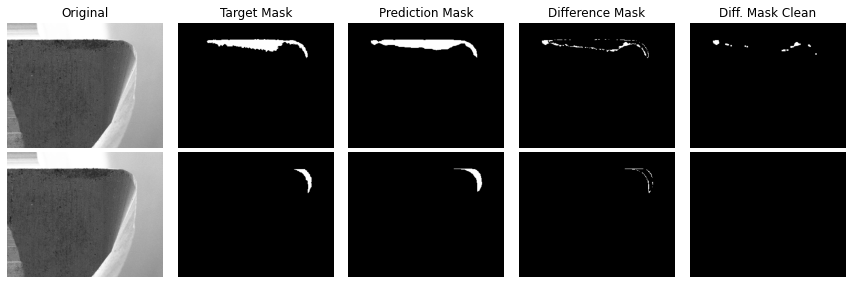

In [83]:
kernel = np.ones((3,3),np.uint8)

custom_objects = {'dice_loss': dice_loss, 'focal_loss': focal_loss, 'iou_wear_metric': iou_wear_metric, 'iou_broken_metric':iou_broken_metric}
iterator = test_ds.as_numpy_iterator()
iterator.next()
input_images, target_images = iterator.next()

fig, ax = plt.subplots(2, 5, figsize=(12,4))
index = 1
row = 0
loss_name= 'categorical_crossentropy'

model = keras.models.load_model('results/'+intro+'_model_'+loss_name+'.h5', custom_objects=custom_objects)    
prediction_images = model.predict(input_images)

prediction_image = prediction_images[index,:,:,:]  
prediction = np.argmax(prediction_image, axis = -1)

input_image = input_images[index,:,:,:]
target_image = target_images[index,:,:,:]

target_wear = target_image[:,:,2].astype(target_image.dtype)  
prediction_wear = np.where(prediction==2, prediction, 0) //2   

difference_wear = (target_wear != prediction_wear).astype(np.uint8)
difference_wear_op = cv2.morphologyEx(difference_wear, cv2.MORPH_OPEN, kernel)  

ax[row][0].imshow(input_image, cmap='gray')
ax[row][1].imshow(target_wear, cmap='gray')
ax[row][2].imshow(prediction_wear, cmap='gray')    
ax[row][3].imshow(difference_wear, cmap='gray')   
ax[row][4].imshow(difference_wear_op, cmap='gray')
for i in range(5):
    ax[row][i].axis('off')
ax[row][0].title.set_text('Original')
ax[row][1].title.set_text('Target Mask')
ax[row][2].title.set_text('Prediction Mask')
ax[row][3].title.set_text('Difference Mask')
ax[row][4].title.set_text('Diff. Mask Clean')

row+=1

target_broken = target_image[:,:,3].astype(target_image.dtype)  
prediction_broken = np.where(prediction==3, prediction, 0) //3   

difference_broken = (target_broken != prediction_broken).astype(np.uint8)
difference_broken_op = cv2.morphologyEx(difference_broken, cv2.MORPH_OPEN, kernel)  

ax[row][0].imshow(input_image, cmap='gray')
ax[row][1].imshow(target_broken, cmap='gray')
ax[row][2].imshow(prediction_broken, cmap='gray')    
ax[row][3].imshow(difference_broken, cmap='gray')   
ax[row][4].imshow(difference_broken_op, cmap='gray')
for i in range(5):
    ax[row][i].axis('off')

plt.tight_layout()  
plt.savefig('results/img_masks_loss.jpeg', dpi=600)
plt.show()

## Plot microm difference

In [12]:
import warnings
custom_objects = {'dice_loss': dice_loss, 'focal_loss': focal_loss, 'iou_wear_metric': iou_wear_metric, 'iou_broken_metric':iou_broken_metric}
kernel = np.ones((3,3),np.uint8)

def get_microm_diff(model, ds, magnifications):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        train_microm_diff = {
            'wear_diff' :[],
            'wear_diff_op' : [],
            'broken_diff' : [],
            'broken_diff_op' : [],
            'iou_wear' : [],
            'iou_broken' : [],
            'vb_microm': [],
            'vb_max_microm' : [],
            'vb_prediction_microm' : [],
            'vb_prediction_max_microm' : [],
            'vb_diff' : [],
            'vb_max_diff' : [],
        }

        batch = 0
        for input_images, target_images in ds.as_numpy_iterator():
            prediction_images = model.predict(input_images) 
            for i in range(len(input_images)):
                input_image = input_images[i,:,:,:]
                target_image = target_images[i,:,:,:]
                prediction_image = prediction_images[i,:,:,:]
                prediction = np.argmax(prediction_image, axis = -1)
                magnification = magnifications[i+batch*batch_size]
                
                target_wear = target_image[:,:,2].astype(target_image.dtype)  
                prediction_wear = np.where(prediction==2, prediction, 0) //2    
                difference_wear = (target_wear != prediction_wear).astype(np.uint8)            
                difference_wear_op = cv2.morphologyEx(difference_wear, cv2.MORPH_OPEN, kernel) 
                wear_diff = get_microm(difference_wear , magnification, df_scale)
                wear_diff_op = get_microm(difference_wear_op , magnification, df_scale)
                m = tf.keras.metrics.MeanIoU(num_classes=2)
                m.update_state(target_wear , prediction_wear)
                iou_wear = m.result().numpy()
                m.reset_state()

                scale = df_scale[df_scale['magnification']==magnification].iloc[0]
                vb, vb_max, _, _, vb_base, _, _, _, _ = get_wear_parameters(target_wear.astype(np.uint8))
                vb_microm = (vb * scale.scale)/scale.pixels
                vb_max_microm = (vb_max * scale.scale)/scale.pixels
                vb, vb_max, _, _, vb_base, _, _, _, _ = get_wear_parameters(prediction_wear.astype(np.uint8))
                vb_prediction_microm = (vb * scale.scale)/scale.pixels
                vb_prediction_max_microm = (vb_max * scale.scale)/scale.pixels

                target_broken = target_image[:,:,3].astype(target_image.dtype)  
                prediction_broken = np.where(prediction==3, prediction, 0) //2
                difference_broken = (target_broken != prediction_broken).astype(np.uint8)
                difference_broken_op = cv2.morphologyEx(difference_broken, cv2.MORPH_OPEN, kernel)            
                broken_diff = get_microm(difference_broken , magnification, df_scale)
                broken_diff_op = get_microm(difference_broken_op , magnification, df_scale)
                m.update_state(target_broken , prediction_broken)
                iou_broken = m.result().numpy()

                train_microm_diff['wear_diff'].append(wear_diff)
                train_microm_diff['wear_diff_op'].append(wear_diff_op)
                train_microm_diff['broken_diff'].append(broken_diff)
                train_microm_diff['broken_diff_op'].append(broken_diff_op)
                train_microm_diff['iou_wear'].append(iou_wear)
                train_microm_diff['iou_broken'].append(iou_broken)
                train_microm_diff['vb_microm'].append(vb_microm)
                train_microm_diff['vb_max_microm'].append(vb_max_microm)
                train_microm_diff['vb_prediction_microm'].append(vb_prediction_microm)
                train_microm_diff['vb_prediction_max_microm'].append(vb_prediction_max_microm)
                train_microm_diff['vb_diff'].append(abs(vb_microm-vb_prediction_microm))
                train_microm_diff['vb_max_diff'].append(abs(vb_max_microm-vb_prediction_max_microm)),

            batch+=1
        return train_microm_diff

In [64]:
train_microm_diff_loss = {}
test_microm_diff_loss = {}

magnification_train = df_train['magnification'].values
magnification_test = df_test['magnification'].values


for loss_name in loss_names:
    if os.path.isfile('results/'+intro+'_model_'+loss_name+'.h5'):
        model = keras.models.load_model('results/'+intro+'_model_'+loss_name+'.h5', custom_objects=custom_objects) 
        train_microm_diff_loss[loss_name] = get_microm_diff(model, train_ds, magnification_train)
        test_microm_diff_loss[loss_name] = get_microm_diff(model, test_ds, magnification_test)

In [66]:
properties = ['loss', 'iou_wear', 'iou_broken', 'MAE(VB)', 'MaxE(VB)', 'R2(VB)', 'MAE(VBmax)', 'MaxE(VBmax)', 'R2(VBmax)', 'Acc(Th=150)', 'train']
df = pd.DataFrame(columns = properties)
th=150

for loss_name in loss_names:
    if loss_name in train_microm_diff_loss:
        d_train = train_microm_diff_loss[loss_name]
        data = {
            'loss' : loss_name,
            'iou_wear': np.array(d_train['iou_wear']).mean(),
            'iou_broken': np.array(d_train['iou_broken']).mean(),
            'MAE(VB)': np.array(d_train['vb_diff']).mean(),
            'MaxE(VB)': np.array(d_train['vb_diff']).max(),
            'R2(VB)': r2_score(d_train['vb_microm'], d_train['vb_prediction_microm']),
            'MAE(VBmax)': np.array(d_train['vb_max_diff']).mean(), 
            'MaxE(VBmax)': np.array(d_train['vb_max_diff']).max(),
            'R2(VBmax)': r2_score(d_train['vb_max_microm'], d_train['vb_prediction_max_microm']),
            'Acc(Th=150)': ((np.array(d_train['wear_diff_op'])<th).sum())/len(d_train['wear_diff_op']),
            'train': True
        }
        df = df.append(data, ignore_index=True)
        d_test = test_microm_diff_loss[loss_name]
        data = {
            'loss' : loss_name,
            'iou_wear': np.array(d_test['iou_wear']).mean(),
            'iou_broken': np.array(d_test['iou_broken']).mean(),
            'MAE(VB)': np.array(d_test['vb_diff']).mean(),
            'MaxE(VB)': np.array(d_test['vb_diff']).max(),
            'R2(VB)': r2_score(d_test['vb_microm'], d_test['vb_prediction_microm']),
            'MAE(VBmax)': np.array(d_test['vb_max_diff']).mean(), 
            'MaxE(VBmax)': np.array(d_test['vb_max_diff']).max(), 
            'R2(VBmax)': r2_score(d_test['vb_max_microm'], d_test['vb_prediction_max_microm']),
            'Acc(Th=150)': ((np.array(d_test['wear_diff_op'])<th).sum())/len(d_test['wear_diff_op']),
            'train': False
        }
        df = df.append(data, ignore_index=True)

In [67]:
d_train = train_microm_diff_loss[loss_name]
d_test = test_microm_diff_loss[loss_name]

print('Train')
print('Mean(VB): '+str(np.array(d_train['vb_microm']).mean()))
print('Max(VB): '+str(np.array(d_train['vb_microm']).max()))
print('Mean(VBmax): '+str(np.array(d_train['vb_max_microm']).mean()))
print('max(VBmax): '+str(np.array(d_train['vb_max_microm']).max()))

print('\nTest')
print('Mean(VB): '+str(np.array(d_test['vb_microm']).mean()))
print('Max(VB): '+str(np.array(d_test['vb_microm']).max()))
print('Mean(VBmax): '+str(np.array(d_test['vb_max_microm']).mean()))
print('max(VBmax): '+str(np.array(d_test['vb_max_microm']).max()))

print('\nTotal')
vb_microm = np.array(d_train['vb_microm'] + d_test['vb_microm'])
vb_max_microm = np.array(d_train['vb_max_microm'] + d_test['vb_max_microm'])
print('Mean(VB): '+str(vb_microm.mean()))
print('Max(VB): '+str(vb_microm.max()))
print('Mean(VBmax): '+str(vb_max_microm.mean()))
print('max(VBmax): '+str(vb_max_microm.max()))

Train
Mean(VB): 2.2900147938276354
Max(VB): 41.93185185185185
Mean(VBmax): 3.7315763910885864
max(VBmax): 56.0

Test
Mean(VB): 1.71867507035681
Max(VB): 6.478452343504246
Mean(VBmax): 2.6782204282204285
max(VBmax): 9.772727272727273

Total
Mean(VB): 2.2026611997432535
Max(VB): 41.93185185185185
Mean(VBmax): 3.5705260992451073
max(VBmax): 56.0


In [68]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    metrics_data = df.groupby(['train','loss'])['iou_wear', 'iou_broken', 'MAE(VB)', 'MaxE(VB)', 'R2(VB)', 'MAE(VBmax)', 'MaxE(VBmax)', 'R2(VBmax)', 'Acc(Th=150)'].max()
    metrics_data = metrics_data.round(2)
    metrics_data = metrics_data.sort_values(by=['train'], ascending= False)

    with open("results/metrics_data.tex", "w") as f:
        f.write(metrics_data.to_latex())

    display(metrics_data)

iou_wear  iou_broken  MAE(VB)  MaxE(VB)  \
train loss                                                                  
True  categorical_crossentropy        0.77        0.83     0.25      4.36   
      categorical_weighted_loss_      0.77        0.83     0.22      4.36   
      dice_loss                       0.76        0.83     0.24      4.36   
      dice_weighted_loss_             0.72        0.83     0.42      4.36   
      focal_loss                      0.76        0.80     0.30      4.36   
      focal_weighted_loss_            0.74        0.82     0.33      4.36   
      iou_loss                        0.76        0.77     0.23      4.36   
      iou_weighted_loss_              0.79        0.81     0.20      2.73   
False categorical_crossentropy        0.74        0.76     0.26      1.24   
      categorical_weighted_loss_      0.73        0.75     0.36      1.24   
      dice_loss                       0.71        0.72     0.32      1.24   
      dice_weighted_loss_             0.68        0.72     0.44      1.44   
      focal_loss                      0.71        0.73     0.33      1.24   
      focal_weighted_loss_            0.70        0.74     0.34      1.16   
      iou_loss                        0.71        0.72     0.28      1.47   
      iou_weighted_loss_              0.73        0.73     0.37      1.55   

                                  R2(VB)  MAE(VBmax)  MaxE(VBmax)  R2(VBmax)  \
train loss                                                                     
True  categorical_crossentropy      0.98        0.47        17.60       0.94   
      categorical_weighted_loss_    0.99        0.49        20.80       0.92   
      dice_loss                     0.98        0.58        22.40       0.91   
      dice_weighted_loss_           0.96        0.85        20.80       0.90   
      focal_loss                    0.98        0.63        22.40       0.91   
      focal_weighted_loss_          0.98        0.70        22.40       0.90   
      iou_loss                      0.98        0.54        20.80       0.92   
      iou_weighted_loss_            0.99        0.47        14.40       0.96   
False categorical_crossentropy      0.95        0.36         1.82       0.96   
      categorical_weighted_loss_    0.93        0.51         2.27       0.93   
      dice_loss                     0.94        0.51         2.05       0.93   
      dice_weighted_loss_           0.89        0.70         2.95       0.88   
      focal_loss                    0.93        0.50         1.82       0.93   
      focal_weighted_loss_          0.93        0.56         2.27       0.93   
      iou_loss                      0.94        0.43         1.82       0.95   
      iou_weighted_loss_            0.91        0.55         1.82       0.92   

                                  Acc(Th=150)  
train loss                                     
True  categorical_crossentropy           0.98  
      categorical_weighted_loss_         0.99  
      dice_loss                          1.00  
      dice_weighted_loss_                0.96  
      focal_loss                         0.99  
      focal_weighted_loss_               0.96  
      iou_loss                           0.98  
      iou_weighted_loss_                 0.99  
False categorical_crossentropy           0.92  
      categorical_weighted_loss_         0.89  
      dice_loss                          0.89  
      dice_weighted_loss_                0.86  
      focal_loss                         0.89  
      focal_weighted_loss_               0.89  
      iou_loss                           0.92  
      iou_weighted_loss_                 0.89

In [59]:
columns = ['Loss', 'Train', 'Threshold', 'Count', 'Total', 'Accuracy']
df_results = pd.DataFrame(columns=columns)

for th in range(50,155, 25): 
    for loss_name in loss_names:
        if loss_name in train_microm_diff_loss:
            d_train = np.array(train_microm_diff_loss[loss_name]['wear_diff_op'])
            d_test = np.array(test_microm_diff_loss[loss_name]['wear_diff_op'])
            th_train = (d_train<th).sum()
            th_test = (d_test<th).sum()
            data = {'Loss': loss_name,'Train': True,'Threshold': th,'Count': th_train,'Total': len(d_train),'Accuracy': th_train/len(d_train)}
            df_results = df_results.append(data, ignore_index=True)
            data['Train'] = False
            data['Count'] = th_test
            data['Total'] = len(d_test)
            data['Accuracy'] = th_test/len(d_test)
            df_results = df_results.append(data, ignore_index=True)

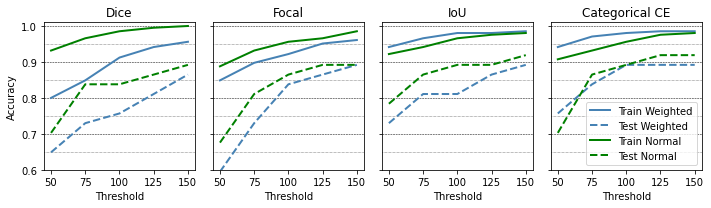

In [84]:
fig, ax = plt.subplots(1, 4, figsize=(10,3), sharex='col', sharey='row')

for h in [0.9, 0.8, 0.7, 0.6, 1.0]:
    ax[0].axhline(h, ls = '--', linewidth=0.5, color='black')
    ax[1].axhline(h, ls = '--', linewidth=0.5, color='black')
    ax[2].axhline(h, ls = '--', linewidth=0.5, color='black')
    ax[3].axhline(h, ls = '--', linewidth=0.5, color='black')
    
for h in [0.85, 0.75, 0.65, 0.95]:
    ax[0].axhline(h, ls = ':', linewidth=0.5, color='black')
    ax[1].axhline(h, ls = ':', linewidth=0.5, color='black')
    ax[2].axhline(h, ls = ':', linewidth=0.5, color='black')
    ax[3].axhline(h, ls = ':', linewidth=0.5, color='black')

titles = ['Dice', 'Focal', 'IoU', 'Categorical CE']
index = 0
for loss_name in loss_names:
    name = 'Weighted' if 'weighted' in loss_name else 'Normal'
    color = 'steelblue' if 'weighted' in loss_name else 'green'
    df_filter = df_results[(df_results['Loss']==loss_name) & (df_results['Train']==True)]
    ax[index//2].plot(df_filter['Threshold'].values, df_filter['Accuracy'].values, label= 'Train '+name, color=color, linewidth=2)
    df_filter = df_results[(df_results['Loss']==loss_name) & (df_results['Train']==False)]
    ax[index//2].plot(df_filter['Threshold'].values, df_filter['Accuracy'].values, '--', label= 'Test '+name, color=color, linewidth=2)
    ax[index//2].title.set_text(titles[index//2]) 
    ax[index//2].set_xlabel('Threshold')
    index += 1

ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.6,1.01)
plt.legend()
plt.tight_layout()  
plt.savefig('results/img_acc_th.jpeg', dpi=600)
plt.show()